In [1]:
import yaml
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from skopt.space import Real, Integer
from skopt import BayesSearchCV

from sklearn.metrics import confusion_matrix
from sklearn import tree
from matplotlib import pyplot as plt
import pickle

In [2]:
# Read config file
with open("config.yaml", 'r') as configuration:
    config = yaml.safe_load(configuration)

In [3]:
# Read and concat the data
PL_20_21 = pd.read_csv('data\\PL_20_21.csv', sep=';')
PL_19_20 = pd.read_csv('data\\PL_19_20.csv', sep=';')
PL_18_19 = pd.read_csv('data\\PL_18_19.csv', sep=';')
PL_17_18 = pd.read_csv('data\\PL_17_18.csv', sep=';')
BL_20_21 = pd.read_csv('data\\BL_20_21.csv', sep=';')
BL_19_20 = pd.read_csv('data\\BL_19_20.csv', sep=';')
BL_18_19 = pd.read_csv('data\\BL_18_19.csv', sep=';')
SP_20_21 = pd.read_csv('data\\SP_20_21.csv', sep=';')
SP_19_20 = pd.read_csv('data\\SP_19_20.csv', sep=';')
SP_18_19 = pd.read_csv('data\\SP_18_19.csv', sep=';')
SP_17_18 = pd.read_csv('data\\SP_17_18.csv', sep=';')
IT_20_21 = pd.read_csv('data\\IT_20_21.csv', sep=';')

data = pd.concat([PL_20_21,PL_19_20,PL_18_19,PL_17_18,BL_20_21,BL_19_20,BL_18_19,SP_20_21,SP_19_20,SP_18_19,SP_17_18,IT_20_21])
data = data.reset_index(drop=True)
data = data.dropna(how='any')
data

,Date,HomeTeam,AwayTeam,FTR,h_course,d_course,a_course,h_pts_3,h_pts_5,h_pts_7,...,a_rc_7,a_pts_per_math,a_gz,a_gs,a_sh_od,a_sh_ot,a_cw,a_cb,a_pozycja,position_dst
1,2020-09-26,Crystal Palace,Everton,A,3.75,3.25,2.10,1.000000,0.8,1.000000,...,0.000000,3.000000,3.000000,1.000000,16.000000,7.500000,8.000000,2.000000,2.0,3.0
2,2020-09-26,West Brom,Chelsea,D,9.00,4.75,1.36,0.666667,1.0,1.142857,...,0.142857,1.500000,1.500000,1.500000,7.500000,15.500000,2.500000,7.000000,9.0,8.0
4,2020-09-27,Sheffield United,Leeds,A,2.70,3.30,2.62,1.000000,0.6,0.428571,...,0.142857,1.500000,3.500000,3.500000,8.000000,18.000000,7.000000,1.500000,8.0,9.0
5,2020-09-27,Tottenham,Newcastle,D,1.45,4.50,7.00,2.000000,1.4,1.571429,...,0.142857,1.500000,1.000000,1.500000,10.500000,14.000000,7.500000,4.000000,12.0,4.0
7,2020-09-27,West Ham,Wolves,H,3.60,3.50,2.05,1.000000,1.2,1.428571,...,0.000000,1.500000,1.500000,1.500000,10.500000,11.500000,8.000000,5.500000,11.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,2020-10-17,Sampdoria,Lazio,H,3.30,3.50,2.15,2.333333,2.0,1.857143,...,0.285714,1.333333,1.333333,1.666667,10.333333,9.000000,5.666667,5.666667,10.0,4.0
3870,2020-10-17,Crotone,Juventus,D,6.50,4.50,1.45,1.666667,1.0,1.142857,...,0.142857,2.000000,2.500000,1.000000,10.000000,8.500000,5.500000,5.500000,9.0,11.0
3871,2020-10-18,Bologna,Sassuolo,A,2.90,3.60,2.30,0.333333,0.6,0.571429,...,0.285714,2.333333,3.000000,1.000000,12.666667,9.666667,4.333333,4.000000,4.0,8.0
3872,2020-10-18,Spezia,Fiorentina,D,5.25,4.00,1.61,1.666667,1.2,1.000000,...,0.142857,1.000000,1.666667,2.000000,13.666667,10.666667,5.666667,2.000000,13.0,2.0


In [4]:
# Dictionary for mapping target
str2idx = {'H':0, 'D':1, 'A':2}
idx2str = {0:'H', 1:'D', 2:'A'}
dicts2translate = {'str2idx' : str2idx,
                   'idx2str' : idx2str }

data = data.replace({'FTR': str2idx})

data_label = data['FTR']
data = data.drop(['FTR','Date','HomeTeam','AwayTeam'], axis=1)
data

,h_course,d_course,a_course,h_pts_3,h_pts_5,h_pts_7,h_gz_3,h_gz_5,h_gz_7,h_gs_3,...,a_rc_7,a_pts_per_math,a_gz,a_gs,a_sh_od,a_sh_ot,a_cw,a_cb,a_pozycja,position_dst
1,3.75,3.25,2.10,1.000000,0.8,1.000000,1.000000,1.0,1.000000,1.333333,...,0.000000,3.000000,3.000000,1.000000,16.000000,7.500000,8.000000,2.000000,2.0,3.0
2,9.00,4.75,1.36,0.666667,1.0,1.142857,1.333333,1.4,1.714286,2.000000,...,0.142857,1.500000,1.500000,1.500000,7.500000,15.500000,2.500000,7.000000,9.0,8.0
4,2.70,3.30,2.62,1.000000,0.6,0.428571,0.333333,0.2,0.285714,2.000000,...,0.142857,1.500000,3.500000,3.500000,8.000000,18.000000,7.000000,1.500000,8.0,9.0
5,1.45,4.50,7.00,2.000000,1.4,1.571429,2.333333,2.0,2.000000,1.333333,...,0.142857,1.500000,1.000000,1.500000,10.500000,14.000000,7.500000,4.000000,12.0,4.0
7,3.60,3.50,2.05,1.000000,1.2,1.428571,0.666667,1.4,1.857143,1.000000,...,0.000000,1.500000,1.500000,1.500000,10.500000,11.500000,8.000000,5.500000,11.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869,3.30,3.50,2.15,2.333333,2.0,1.857143,2.000000,1.8,1.428571,0.666667,...,0.285714,1.333333,1.333333,1.666667,10.333333,9.000000,5.666667,5.666667,10.0,4.0
3870,6.50,4.50,1.45,1.666667,1.0,1.142857,1.000000,0.6,1.000000,0.666667,...,0.142857,2.000000,2.500000,1.000000,10.000000,8.500000,5.500000,5.500000,9.0,11.0
3871,2.90,3.60,2.30,0.333333,0.6,0.571429,1.000000,1.4,1.142857,2.666667,...,0.285714,2.333333,3.000000,1.000000,12.666667,9.666667,4.333333,4.000000,4.0,8.0
3872,5.25,4.00,1.61,1.666667,1.2,1.000000,2.666667,2.0,1.571429,1.666667,...,0.142857,1.000000,1.666667,2.000000,13.666667,10.666667,5.666667,2.000000,13.0,2.0


In [5]:
data = data.drop(['h_course','d_course','a_course'], axis=1)

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, data_label, test_size=0.30, random_state=20)

In [20]:
model = xgb.XGBRegressor(objective='multi:softmax',
                        num_class=3)

In [21]:
params = {
        'learning_rate': Real(0.1, 0.3),
        'n_estimators': Integer(20, 80),
        'min_child_weight': Integer(10, 300),
        'gamma': Real(0.5,5),
        'colsample_bytree': Real(0.7, 0.95),
        'subsample': Real(0.7, 0.9),
        'max_depth': Integer(2,3),
        'lambda': Real(1,10)
        }

In [22]:
# BAYESIAN OPTIMIZATION
bayes_optim = BayesSearchCV(estimator=model,
                            search_spaces=params,
                            n_iter = 20,
                            n_jobs=-1,
                            cv=5,
                            verbose=1,
                            random_state=19)

bayes_optim.fit(X_train, y_train)


print('\nBEST PARAMETERS:',bayes_optim.best_params_, '\n')

print('BEST SCORE:',bayes_optim.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [12]:
# Ręczne dopasowania hiperparametrów
#bayes_optim.best_params_['learning_rate'] = 0.2


In [23]:
# DataFrames to DMatrix
X_train = xgb.DMatrix(X_train, label=y_train)
X_test = xgb.DMatrix(X_test, label=y_test)

# Parameters definition
param = {'max_depth': bayes_optim.best_params_['max_depth'],
         'eta': bayes_optim.best_params_['learning_rate'],
         'gamma':bayes_optim.best_params_['gamma'],
         'min_child_weight':bayes_optim.best_params_['min_child_weight'],
         'colsample_bytree':bayes_optim.best_params_['colsample_bytree'],
         'subsample':bayes_optim.best_params_['subsample'],
         'lambda':bayes_optim.best_params_['lambda'],
         'objective': 'multi:softprob',
         'eval_metric' : ['auc','merror'],
         'num_class' : 3
        }
evallist = [(X_test, 'test'), (X_train, 'train')]

xgb_model = xgb.train(param, X_train, bayes_optim.best_params_['n_estimators'], evallist)

[0]	test-auc:0.64748	test-merror:0.47541	train-auc:0.68453	train-merror:0.48847
[1]	test-auc:0.66650	test-merror:0.46539	train-auc:0.70671	train-merror:0.46932
[2]	test-auc:0.67446	test-merror:0.45993	train-auc:0.71907	train-merror:0.46503
[3]	test-auc:0.68064	test-merror:0.45902	train-auc:0.72960	train-merror:0.45721
[4]	test-auc:0.68409	test-merror:0.44900	train-auc:0.73699	train-merror:0.44822
[5]	test-auc:0.68481	test-merror:0.45173	train-auc:0.74157	train-merror:0.44705
[6]	test-auc:0.69032	test-merror:0.44718	train-auc:0.74700	train-merror:0.44510
[7]	test-auc:0.69049	test-merror:0.45720	train-auc:0.75063	train-merror:0.43845
[8]	test-auc:0.68976	test-merror:0.45902	train-auc:0.75440	train-merror:0.43376
[9]	test-auc:0.69125	test-merror:0.45628	train-auc:0.75690	train-merror:0.43298
[10]	test-auc:0.69084	test-merror:0.45902	train-auc:0.75936	train-merror:0.42907
[11]	test-auc:0.69107	test-merror:0.45173	train-auc:0.76260	train-merror:0.42946
[12]	test-auc:0.69164	test-merror:0.45

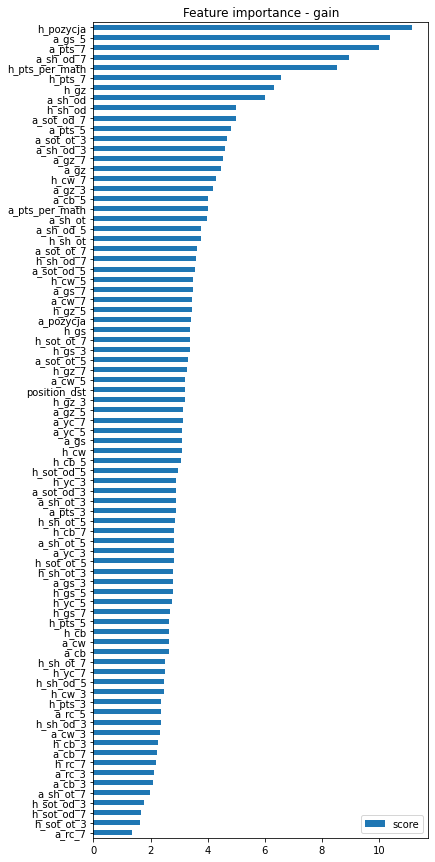

In [24]:
# Feature importance
feature_important = xgb_model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_score = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data_score.plot(kind='barh', figsize=(6,15))
plt.title('Feature importance - gain')
plt.show()

In [25]:
train_probabilities = pd.DataFrame(xgb_model.predict(X_train))
train_probabilities['FTR'] = train_probabilities.idxmax(axis = 1)

test_probabilities = pd.DataFrame(xgb_model.predict(X_test))
test_probabilities['FTR'] = test_probabilities.idxmax(axis = 1)


# ACCURACY
print('TRAIN:', sum(np.array(train_probabilities['FTR']) == np.array(y_train))/len(np.array(y_train)))
print('TEST:', sum(np.array(test_probabilities['FTR']) == np.array(y_test))/len(np.array(y_test)))

# Confucion matrix
print('TRAIN:\n', confusion_matrix(np.array(y_train), np.array(train_probabilities['FTR'])))
print('TEST:\n', confusion_matrix(np.array(y_test), np.array(test_probabilities['FTR'])))

TRAIN: 0.662758890191481
TEST: 0.5437158469945356
TRAIN:
 [[958  26 145]
 [279 223 141]
 [225  47 515]]
TEST:
 [[378  33  78]
 [152  26  90]
 [125  23 193]]


In [26]:
train_probabilities = pd.DataFrame(xgb_model.predict(X_train))
#train_preds['FTR'] = train_preds.idxmax(axis = 1)
#train_preds = train_preds.replace({'FTR': idx2str})

test_probabilities = pd.DataFrame(xgb_model.predict(X_test))
#test_preds['FTR'] = test_preds.idxmax(axis = 1)
#test_preds = test_preds.replace({'FTR': idx2str})

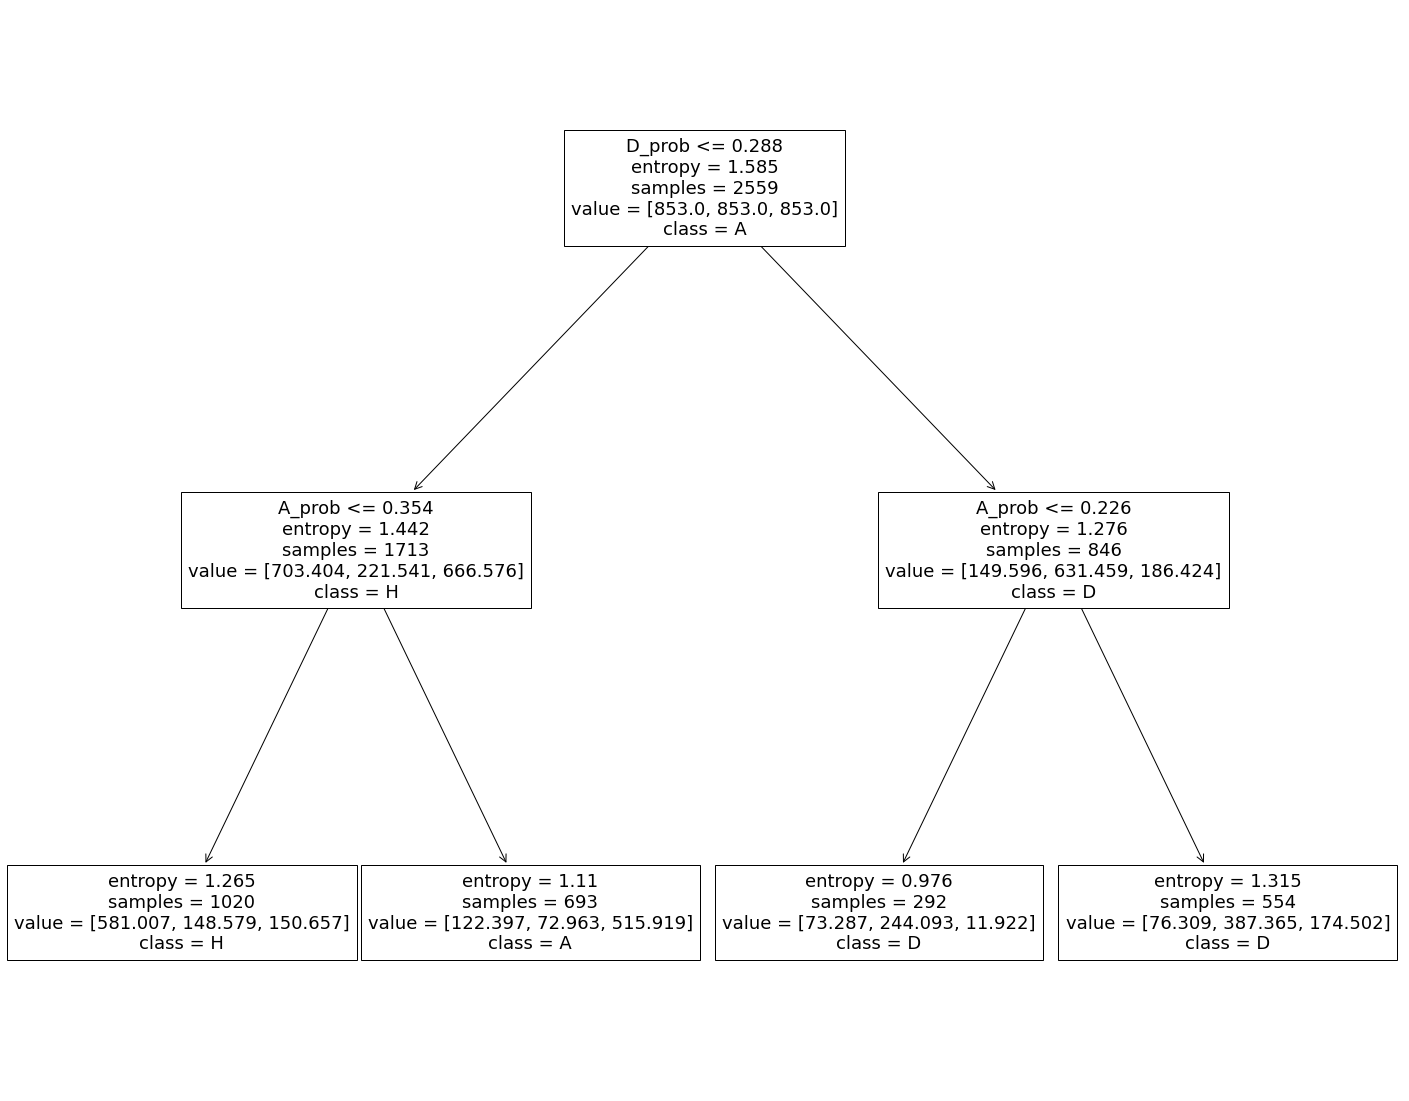

In [39]:
# Decision tree
decision_tree = DecisionTreeClassifier(criterion='entropy',
                             class_weight = 'balanced',
                             max_depth = 2,
                             min_samples_leaf = 0.03
                            )
decision_tree.fit(train_probabilities, np.array(y_train))

# Plot tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree, 
                   feature_names=['H_prob','D_prob','A_prob'],
                   class_names=['H','D','A'])

In [40]:
# Predictions after decision tree
tree_preds_train = decision_tree.predict(train_probabilities)
tree_preds_test = decision_tree.predict(test_probabilities)

In [41]:
# ACCURACY
print('TRAIN:', sum(np.array(tree_preds_train) == np.array(y_train))/len(np.array(y_train)))
print('TEST:', sum(np.array(tree_preds_test) == np.array(y_test))/len(np.array(y_test)))

# Confucion matrix
print('TRAIN:\n', confusion_matrix(np.array(y_train), np.array(tree_preds_train)))
print('TEST:\n', confusion_matrix(np.array(y_test), np.array(tree_preds_test)))

TRAIN: 0.6725283313794451
TEST: 0.48360655737704916
TRAIN:
 [[769 198 162]
 [112 476  55]
 [139 172 476]]
TEST:
 [[268 144  77]
 [ 93 106  69]
 [ 85  99 157]]


In [11]:
# ACCURACY - stara wersja
print('TRAIN:', sum(np.array(tree_preds_train) == np.array(y_train))/len(np.array(y_train)))
print('TEST:', sum(np.array(tree_preds_test) == np.array(y_test))/len(np.array(y_test)))

# Confucion matrix
print('TRAIN:\n', confusion_matrix(np.array(y_train), np.array(tree_preds_train)))
print('TEST:\n', confusion_matrix(np.array(y_test), np.array(tree_preds_test)))

TRAIN: 0.5630613041780554
TEST: 0.517304189435337
TRAIN:
 [[674 219 264]
 [201 274 150]
 [133 152 494]]
TEST:
 [[271  96  94]
 [ 92  95 101]
 [ 58  89 202]]


In [42]:
# Save model and components
pickle.dump(xgb_model, open('model\\xgb_model.pkl', "wb"))
pickle.dump(decision_tree, open('model\\tree_model.pkl', "wb"))
pickle.dump(dicts2translate, open('model\\dicts2translate.pkl', "wb"))